### Trabalho de Ciência de Redes - Simulação de Epidemias

#### Alunos:
- Isaías Gouvêa Gonçalves
- Bruno Ferreira
- Elisa Soares

In [1]:
# Configuração do Ambiente

import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

---
## Exercício 1
Gere uma rede aleatória (Erdos-Renyi) com $10000$ vértices e grau médio $<k> = 20$.
Comece com $5$ vértices aleatórios infectados e faça a simulação computacional da propagação
da infecção pelo modelo SIS com os parâmetros abaixo.

***a.*** $\beta$ = 0.02 e $\mu$ = 0.1

***b.*** $\beta$ = 0.02 e $\mu$ = 0.4

***c.*** $\beta$ = 0.02 e $\mu$ = 0.5

Em cada caso, descreva o que você encontrou nas simulações e compare com o esperado pela
teoria

In [8]:
"""
Em uma rede aleatória de N vértices e grau médio k,
a probabilidade p de uma arestas entre quaisquer dois vértices existir
é dada por:
p = k / (N-1)

Para fins computacionais iremos utilizar a aproximação
p = k / N

"""

N = 10000
k = 20
p = k / N
beta = 0.02
num_simulations = 100
max_iter = 1000

base_G = nx.erdos_renyi_graph(N, p)
adj_matrix = nx.to_scipy_sparse_array(base_G)

scenarios = {
    0.1: None,
    0.4: None,
    0.5: None
}

In [9]:
for mu in scenarios.keys():
    all_runs = np.zeros((num_simulations, max_iter + 1))
    
    for sim in range(num_simulations):
        states = np.zeros(N)
        initially_infected = np.random.choice(N, 5, replace=False)
        states[initially_infected] = 1
        
        all_runs[sim, 0] = 5
        
        for t in range(max_iter):
            if np.sum(states) == 0:
                all_runs[sim, t+1:] = 0
                break
            
            infected_indices = np.where(states == 1)[0]
            susceptible_indices = np.where(states == 0)[0]
            
            recover_probs = np.random.random(len(infected_indices))
            recovering = infected_indices[recover_probs < mu]
            
            infected_neighbors_count = adj_matrix @ states
            
            prob_infection = 1 - (1 - beta) ** infected_neighbors_count
            
            infection_rolls = np.random.random(N)
            new_infections = (states == 0) & (infection_rolls < prob_infection)
            
            states[recovering] = 0
            states[new_infections] = 1
            
            all_runs[sim, t + 1] = np.sum(states)
            
    scenarios[mu] = np.mean(all_runs, axis=0)

print(scenarios.items())

dict_items([(0.1, array([5.00000e+00, 6.90000e+00, 8.99000e+00, ..., 7.06526e+03,
       7.06421e+03, 7.06027e+03], shape=(1001,))), (0.4, array([5.  , 4.77, 4.63, ..., 1.93, 2.01, 2.06], shape=(1001,))), (0.5, array([5.  , 4.35, 3.98, ..., 0.  , 0.  , 0.  ], shape=(1001,)))])


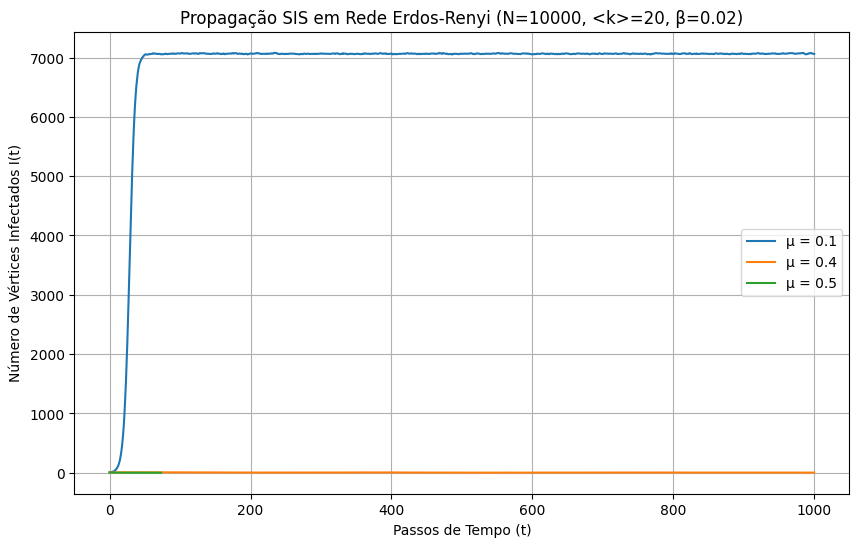

In [10]:
plt.figure(figsize=(10, 6))
plt.title(f'Propagação SIS em Rede Erdos-Renyi (N=10000, <k>=20, β=0.02)')
plt.xlabel('Passos de Tempo (t)')
plt.ylabel('Número de Vértices Infectados I(t)')

# Itera sobre os cenários e plota cada um
for mu, history in scenarios.items():
    # Remove os zeros extras do array, mantendo apenas a simulação
    history_trimmed = history[history != 0]
    
    # Adiciona a última etapa (0 infectados) se a simulação parou
    if history_trimmed[-1] == 0 and len(history) > len(history_trimmed):
        history_trimmed = history[:len(history_trimmed) + 1]

    plt.plot(history_trimmed, label=f'μ = {mu}')

plt.grid(True)
plt.legend()
plt.show()

Cenário    | R0         | Teórico (I*)    | Simulado (Final)
------------------------------------------------------------
μ = 0.1    | 4.00       | 7500            | 7066           
μ = 0.4    | 1.00       | 0               | 1              
μ = 0.5    | 0.80       | 0               | 0              


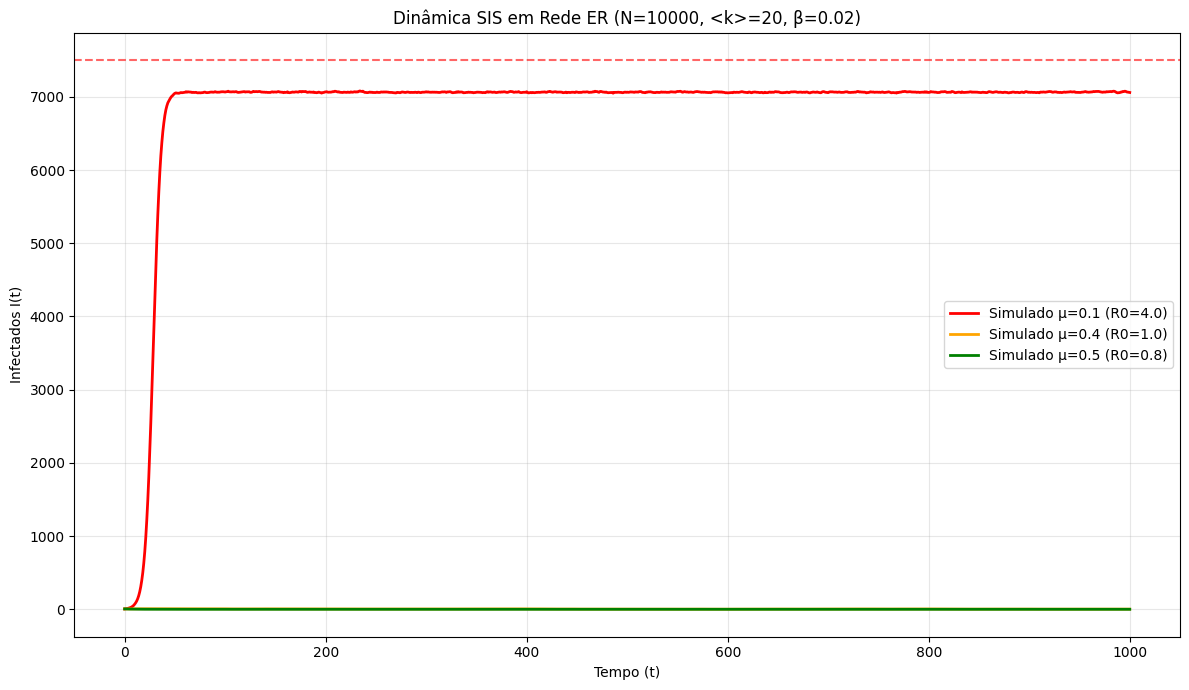

In [11]:

print(f"{'Cenário':<10} | {'R0':<10} | {'Teórico (I*)':<15} | {'Simulado (Final)':<15}")
print("-" * 60)

plt.figure(figsize=(12, 7))
plt.title(f'Dinâmica SIS em Rede ER (N={N}, <k>={k}, β={beta})')
plt.xlabel('Tempo (t)')
plt.ylabel('Infectados I(t)')

colors = {0.1: 'red', 0.4: 'orange', 0.5: 'green'} # Cores consistentes

for mu, history in scenarios.items():
    # 1. Cálculo Teórico (Campo Médio)
    R0 = (beta * k) / mu
    
    if R0 > 1:
        # Fração endêmica teórica: i* = 1 - (1/R0)
        theoretical_I = N * (1 - (1 / R0))
        label_theory = f'Teórico μ={mu} (I*={int(theoretical_I)})'
        # Plota linha tracejada do limite teórico
        plt.axhline(y=theoretical_I, color=colors.get(mu, 'black'), linestyle='--', alpha=0.6)
    else:
        theoretical_I = 0
        label_theory = f'Teórico μ={mu} (Extinção)'

    # 2. Exibição dos dados (Simulado vs Teórico)
    # Pegamos a média dos últimos 100 passos para evitar ruído momentâneo
    simulated_final = np.mean(history[-100:]) 
    print(f"μ = {mu:<6} | {R0:<10.2f} | {int(theoretical_I):<15} | {int(simulated_final):<15}")

    # 3. Plotagem da Curva
    # Não cortamos os zeros. É importante ver quando a doença morre no tempo.
    plt.plot(history, label=f'Simulado μ={mu} (R0={R0:.1f})', color=colors.get(mu, 'blue'), linewidth=2)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

No nosso exemplo o limiar crítico é $\lambda _c = \frac{1}{<k>} = 0.05$

### a\)
Podemos perceber que o caso com $\mu = 0.1$ teve um cescimento de início exponencial no número de infectados, até que estabilizasse em uma faixa de 7000 mil infectados em média, mantendo isso até o final do experimento. 

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.1} = 0.2 > \lambda _c$

Com isso, podemos concluir que a doença atinge um estado endêmico permanente

### b\)
No caso de $\mu = 0.4$ já temos um exemplo claro de uma curva de infecção que tem um ápice próximo da iteração $t = 150$, e depois diminui a ponto de que antes da iteração $t = 400$ já não há nenhum infectado.  

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.4} = 0.05 = \lambda _c$

Portanto, com uma taxa de infecção igual ao limiar crítico, temos um processo de infecção estocástico equilibrado

### c\)
Por fim, para $\mu = 0.5$, a alta taxa de recuperação garantiu que a infecção não se proliferasse, a ponto de que o número de infectados aumentasse em apenas dois e logo decaísse para zero antes da décima iteração.

Aqui a taxa efetiva de infecção é $\lambda = \frac{\beta}{\mu} = \frac{0.02}{0.5} = 0.04 < \lambda _c$

Essa taxa de infecção não permite que a doença de espalhe, e faz com que ela desapareça quase que imediatamente

Gráficos detalhados podem ser vistos abaixo:

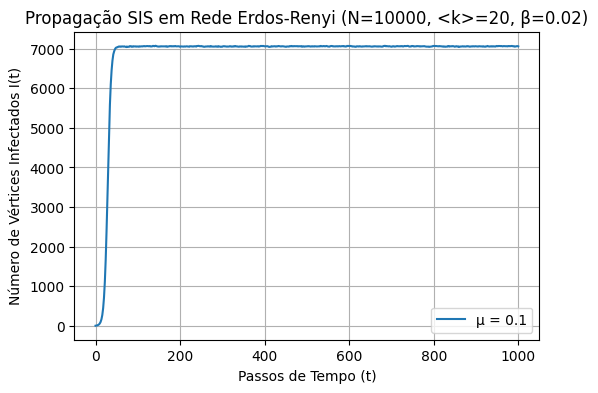

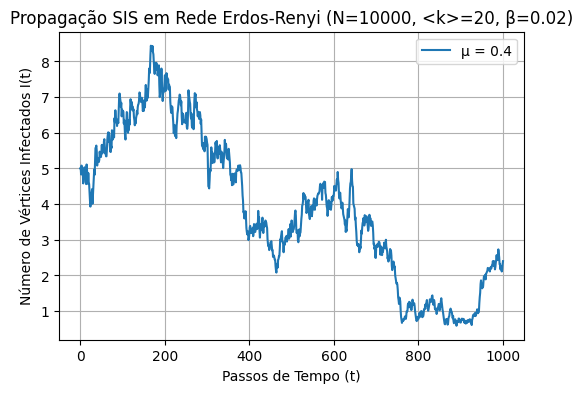

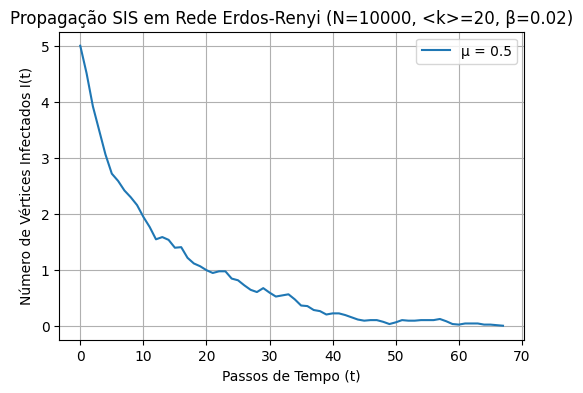

In [8]:
for mu, history in scenarios.items():
    # Remove os zeros extras do array, mantendo apenas a simulação
    history_trimmed = history[history != 0]
    
    # Adiciona a última etapa (0 infectados) se a simulação parou
    if history_trimmed[-1] == 0 and len(history) > len(history_trimmed):
        history_trimmed = history[:len(history_trimmed) + 1]

    plt.figure(figsize=(6, 4))
    plt.title(f'Propagação SIS em Rede Erdos-Renyi (N=10000, <k>=20, β=0.02)')
    plt.xlabel('Passos de Tempo (t)')
    plt.ylabel('Número de Vértices Infectados I(t)')

    plt.plot(history_trimmed, label=f'μ = {mu}')
    plt.grid(True)
    plt.legend()
    plt.show()

---
## Exercício 2

In [14]:
# Parâmetros
N = 10000
k = 20                  # grau médio desejado
m = k // 2              # em BA, <k> ≈ 2m
beta = 0.01             # taxa de infecção base (fixa)
initially_infected_num = 5
num_simulations = 100   # número de simulações por cenário
max_iter = 1000

# Rede que iremos utilizar
G_base_2 = nx.barabasi_albert_graph(N, m)
adj_matrix = nx.to_scipy_sparse_array(G_base_2)

# Cenários de recuperação
scenarios_mu = [0.1, 0.2, 0.3]
results = {mu: np.zeros(max_iter + 1) for mu in scenarios_mu}

In [15]:
for mu in scenarios_mu:

    all_runs = np.zeros((num_simulations, max_iter + 1))

    for sim in range(num_simulations):

        states = np.zeros(N)
        initially_infected = np.random.choice(N, initially_infected_num, replace=False)
        states[initially_infected] = 1

        all_runs[sim, 0] = initially_infected_num

        for t in range(max_iter):
            if np.sum(states) == 0:
                all_runs[sim, t+1:] = 0
                break

            infected_neighbors_count = adj_matrix @ states
            
            prob_infection = 1 - (1 - beta) ** infected_neighbors_count
            
            infection_rolls = np.random.random(N)
            new_infections = (states == 0) & (infection_rolls < prob_infection)
            
            infected_indices = np.where(states == 1)[0]
            recover_probs = np.random.random(len(infected_indices))
            recovering = infected_indices[recover_probs < mu]
            
            states[recovering] = 0
            states[new_infections] = 1
            
            num_infected = np.sum(states)
            all_runs[sim, t+1] = num_infected

    results[mu] = np.mean(all_runs, axis=0)

print(results.items())

dict_items([(0.1, array([   5.  ,    5.41,    6.31, ..., 4436.57, 4436.57, 4440.35],
      shape=(1001,))), (0.2, array([   5.  ,    5.03,    5.55, ..., 1381.34, 1379.98, 1378.51],
      shape=(1001,))), (0.3, array([  5.  ,   4.22,   4.15, ..., 254.58, 252.92, 254.19], shape=(1001,)))])


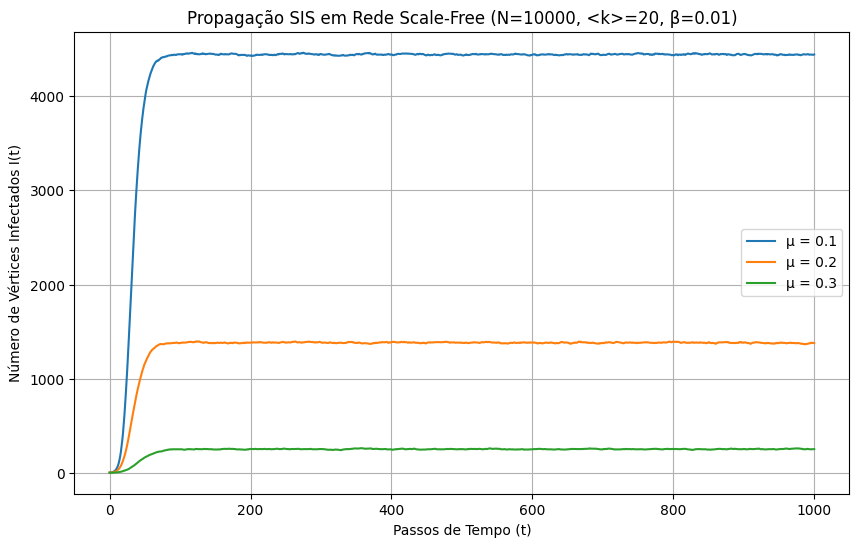

In [16]:
plt.figure(figsize=(10, 6))
plt.title(f'Propagação SIS em Rede Scale-Free (N=10000, <k>=20, β=0.01)')
plt.xlabel('Passos de Tempo (t)')
plt.ylabel('Número de Vértices Infectados I(t)')

# Itera sobre os cenários e plota cada um
for mu, history in results.items(): 
    
    # Remove os zeros extras do array (simulações que terminaram cedo)
    history_trimmed = history[history != 0]
    
    # Mantém o último zero real se a epidemia extinguiu
    if len(history_trimmed) > 0 and history_trimmed[-1] != 0:
        history_trimmed = history
    else:
        first_zero_index = np.where(history == 0)[0][0]
        history_trimmed = history[:first_zero_index + 1]

    plt.plot(history_trimmed, label=f'μ = {mu}')

plt.grid(True)
plt.legend()
plt.show()

---
## Exercício 3

In [13]:
# Parâmetros
N = 10000
k = 20
p = k / N

beta = 0.02
mu = 0.1
initial_infected = 5
num_simulations = 100   # número de simulações por cenário
max_iter = 1000
G = nx.erdos_renyi_graph(N, p) 
adj_matrix_sparse = nx.to_scipy_sparse_array(G)

In [14]:
def run_sis(G, immunized_set):
    
    is_immunized = np.zeros(N, dtype=bool)
    if immunized_set:
        is_immunized[list(immunized_set)] = True

    available_nodes = np.where(~is_immunized)[0]
    states = np.zeros(N)
    
    initial = np.random.choice(available_nodes, initial_infected, replace=False)
    states[initial] = 1

    for t in range(max_iter):
        
        if np.sum(states) == 0:
            return 0

        infected_neighbors_count = adj_matrix @ states
        
        prob_infection = 1 - (1 - beta) ** infected_neighbors_count
        
        infection_rolls = np.random.random(N)
        
        # Só infecta se: for suscetível (0) E a chance bater E não for imunizado
        new_infections = (states == 0) & (infection_rolls < prob_infection) & (~is_immunized)
        
        infected_indices = np.where(states == 1)[0]
        recover_probs = np.random.random(len(infected_indices))
        recovering = infected_indices[recover_probs < mu]

        states[new_infections] = 1
        states[recovering] = 0

    return np.sum(states)

In [15]:
fractions = np.linspace(0, 0.5, 20)
results_random = {}
results_hubs = {}
results_neighbors = {}

sorted_by_degree = [n for n, d in sorted(G.degree(), key=lambda x: x[1], reverse=True)]

for frac in fractions:
    print(f"Testando fração de vacinação = {frac:.3f}")
    num_vaccinated = int(frac * N)
    
    if num_vaccinated == 0:
        base_val = np.mean([run_sis(G, set()) for _ in range(num_simulations)])
        results_random[frac] = results_hubs[frac] = results_neighbors[frac] = base_val
        continue

    immunized_random = set(random.sample(range(N), num_vaccinated))

    immunized_hubs = set(sorted_by_degree[:num_vaccinated])

    vacc_neighbors = set()
    candidates = np.random.permutation(N)
    idx = 0
    while len(vacc_neighbors) < num_vaccinated and idx < N:
        vacc_neighbors.update(G[candidates[idx]])
        idx += 1
    
    immunized_neighbors = set(list(vacc_neighbors)[:num_vaccinated])

    results_random[frac] = np.mean([run_sis(G, immunized_random) for _ in range(num_simulations)])
    results_hubs[frac] = np.mean([run_sis(G, immunized_hubs) for _ in range(num_simulations)])
    results_neighbors[frac] = np.mean([run_sis(G, immunized_neighbors) for _ in range(num_simulations)])

print("\nFrações testadas:", fractions)
print("\nVacinação aleatória:", results_random)
print("\nVacinação hubs:", results_hubs)
print("\nVacinação vizinhos:", results_neighbors)

Testando fração de vacinação = 0.000
Testando fração de vacinação = 0.026
Testando fração de vacinação = 0.053
Testando fração de vacinação = 0.079
Testando fração de vacinação = 0.105
Testando fração de vacinação = 0.132
Testando fração de vacinação = 0.158
Testando fração de vacinação = 0.184
Testando fração de vacinação = 0.211
Testando fração de vacinação = 0.237
Testando fração de vacinação = 0.263
Testando fração de vacinação = 0.289
Testando fração de vacinação = 0.316
Testando fração de vacinação = 0.342
Testando fração de vacinação = 0.368
Testando fração de vacinação = 0.395
Testando fração de vacinação = 0.421
Testando fração de vacinação = 0.447
Testando fração de vacinação = 0.474
Testando fração de vacinação = 0.500

Frações testadas: [0.         0.02631579 0.05263158 0.07894737 0.10526316 0.13157895
 0.15789474 0.18421053 0.21052632 0.23684211 0.26315789 0.28947368
 0.31578947 0.34210526 0.36842105 0.39473684 0.42105263 0.44736842
 0.47368421 0.5       ]

Vacinação aleat

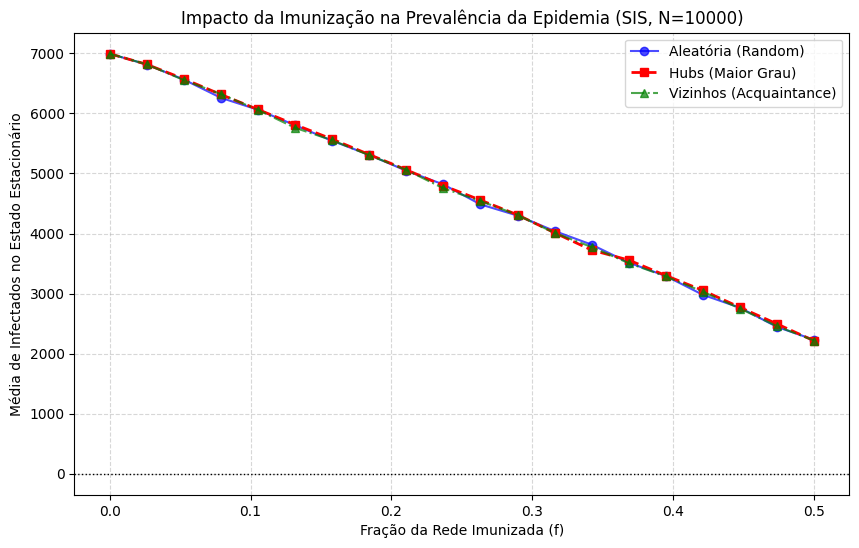

In [16]:
plt.figure(figsize=(10, 6))

# Garante que vamos plotar na ordem correta do eixo X (fração de vacinados)
sorted_fracs = sorted(fractions)

# Função auxiliar para extrair os valores na ordem das frações
def get_y_values(results_dict):
    return [results_dict[f] for f in sorted_fracs]

# Plotagem das 3 curvas
plt.plot(sorted_fracs, get_y_values(results_random), 
         marker='o', linestyle='-', label='Aleatória (Random)', color='blue', alpha=0.7)

plt.plot(sorted_fracs, get_y_values(results_hubs), 
         marker='s', linestyle='--', label='Hubs (Maior Grau)', color='red', linewidth=2)

plt.plot(sorted_fracs, get_y_values(results_neighbors), 
         marker='^', linestyle='-.', label='Vizinhos (Acquaintance)', color='green', alpha=0.7)

# Detalhes estéticos
plt.axhline(0, color='black', linewidth=1, linestyle=':') # Linha de referência zero
plt.title(f'Impacto da Imunização na Prevalência da Epidemia (SIS, N={N})')
plt.xlabel('Fração da Rede Imunizada (f)')
plt.ylabel('Média de Infectados no Estado Estacionário')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()